## Overview

The purpose of this kernel is to take a look at the data, come up with some insights, and attempt to create a predictive model or two. This notebook is still **very** raw. I will work on it as my very limited time permits, and hope to expend it in the upcoming days and weeks.


## Packages

First, let's load a few useful Python packages. This section will keep growing in subsequent versions of this EDA.

In [2]:
!pip install opencv-python

     |████████████████████████████████| 28.2MB 66kB/s  eta 0:00:01     |████████████████                | 14.2MB 433kB/s eta 0:00:33


In [4]:
!pip install pillow

     |████████████████████████████████| 2.1MB 393kB/s eta 0:00:01


In [6]:
!pip install seaborn

     |████████████████████████████████| 225kB 1.3MB/s eta 0:00:01


In [8]:
!pip install imagesize

In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import math
import cv2
import PIL
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
import os
import imagesize

%matplotlib inline

Let's see what files we have in the input directory:

In [2]:
import os
print(os.listdir("../input/siimisic-melanoma-resized-images/"))

['x_train_96.npy', 'x_test_64.npy', 'x_test_224.npy', 'x_train_32.npy', 'x_train_224.npy', 'x_test_96.npy', 'x_test_128.npy', 'x_train_64.npy', 'x_test_32.npy', 'x_train_128.npy']


In [10]:
#Loading Train and Test Data
train = pd.read_csv("/home/mvernier/Descargas/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("/home/mvernier/Descargas/siim-isic-melanoma-classification/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [11]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


### Lets see Cancer in which body part is more common ? 

In [12]:
grp = train.groupby(['anatom_site_general_challenge']).mean().sort_values(by = 'target')
grp

,age_approx,target
anatom_site_general_challenge,,
palms/soles,44.346667,0.013333
lower extremity,49.074890,0.014732
torso,48.723031,0.015257
upper extremity,48.516019,0.022276
oral/genital,44.354839,0.032258
head/neck,52.295393,0.039892


In [13]:
%matplotlib inline

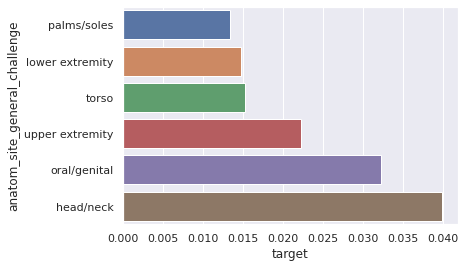

In [14]:
import seaborn as sns
sns.set(style="darkgrid")
# titanic = sns.load_dataset("titanic")
ax = sns.barplot(x="target", y=grp.index, data=grp)
# plt.bar( grp.index , grp['target'])

* Most common in head/neck area

In [15]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Let's look at the distribution of the target:

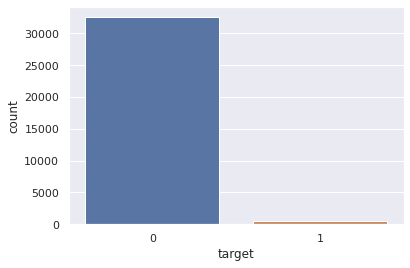

In [16]:
import seaborn as sns
sns.set(style="darkgrid")
# titanic = sns.load_dataset("titanic")
ax = sns.countplot(x="target", data=train)

In [17]:
np.mean(train.target)

0.01762965646320111

So this is a binary classification problem with highly imbalanced data.

Let's now look at the distributions of various "features"

/home/mvernier/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mvernier/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


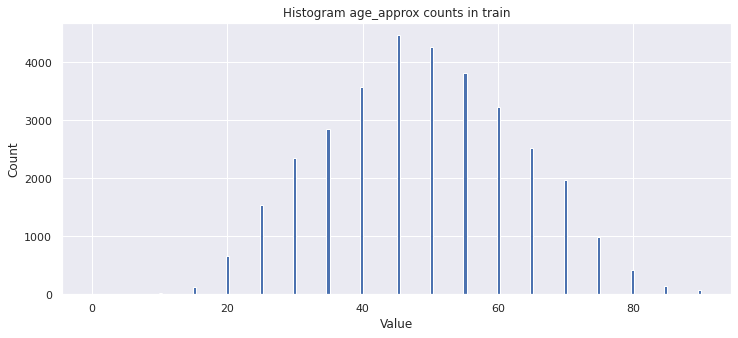

In [18]:
plt.figure(figsize=(12, 5))
plt.hist(train['age_approx'].values, bins=200)
plt.title('Histogram age_approx counts in train')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

Let's take a look at a few images.

In [20]:
images = []
for i, image_id in enumerate(tqdm(train['image_name'].head(10))):
    im = Image.open(f'/home/mvernier/Descargas/siim-isic-melanoma-classification/jpeg/train/{image_id}.jpg')
    im = im.resize((128, )*2, resample=Image.LANCZOS)
    images.append(im)
    

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


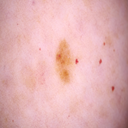

In [25]:
images[9]

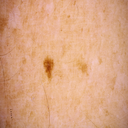

In [14]:
images[1]

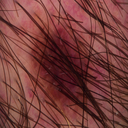

In [15]:
images[3]

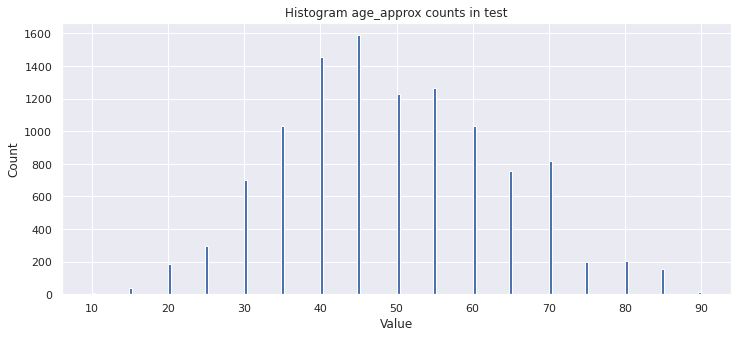

In [26]:
plt.figure(figsize=(12, 5))
plt.hist(test['age_approx'].values, bins=200)
plt.title('Histogram age_approx counts in test')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

Now we will load some of the resized images (32x32 for now) and try to build some simple models. 

In [17]:
x_train_32 = np.load('../input/siimisic-melanoma-resized-images/x_train_32.npy')
x_test_32 = np.load('../input/siimisic-melanoma-resized-images/x_test_32.npy')

### 33126 images with resolution 32x32x3

In [18]:
x_train_32.shape

(33126, 32, 32, 3)

In [19]:
x_train_32 = x_train_32.reshape((x_train_32.shape[0], 32*32*3))
x_train_32.shape

(33126, 3072)

In [20]:
x_test_32 = x_test_32.reshape((x_test_32.shape[0], 32*32*3))
x_test_32.shape

(10982, 3072)

In [21]:
y = train.target.values

In [22]:
train_oof = np.zeros((x_train_32.shape[0], ))
test_preds = 0
train_oof.shape

(33126,)

Let's look at training data now

In [23]:
x_train_32

array([[172, 122, 133, ..., 150,  86, 100],
       [162, 104,  76, ..., 164, 120,  98],
       [198, 133, 150, ..., 137,  80,  98],
       ...,
       [131,  89,  71, ..., 132, 100,  76],
       [136,  89, 103, ..., 127,  98, 103],
       [203, 119, 138, ..., 153, 103, 100]], dtype=uint8)

## Training our first model : 
* Image data only
* Logistic Regression. No Neural Nets used.

In [24]:
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(x_train_32)):
    print("Fitting fold", jj+1)
    train_features = x_train_32[train_index]
    train_target = y[train_index]
    
    val_features = x_train_32[val_index]
    val_target = y[val_index]
    
    model = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial', max_iter=60)
    model.fit(train_features, train_target)
    val_pred = model.predict_proba(val_features)[:,1]
    train_oof[val_index] = val_pred
    print(len(train_oof))
    print("Fold AUC:", roc_auc_score(val_target, val_pred))
    test_preds += model.predict_proba(x_test_32)[:,1]/n_splits
    del train_features, train_target, val_features, val_target
    gc.collect()

Fitting fold 1


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


33126
Fold AUC: 0.8367913986288544
Fitting fold 2


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


33126
Fold AUC: 0.8044596385962464
Fitting fold 3


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


33126
Fold AUC: 0.8301575710991544
Fitting fold 4


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


33126
Fold AUC: 0.8013225413667892
Fitting fold 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


33126
Fold AUC: 0.8380336027707896


In [25]:
print(roc_auc_score(y, train_oof))

0.8227076726136003


In [26]:
train['age_approx'].unique()

array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., nan, 80.,
       20., 85., 15., 90., 10.,  0.])

Wow, so we get an 0.82 AUC with just unravelled resized images and a simple Logistic Regression!

* Let's now add some non-image features. We can start with sex, and one-hot encode it.

In [27]:
train['sex'] = (train['sex'].values == 'male')*1
test['sex'] = (test['sex'].values == 'male')*1
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,1,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,0,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,0,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,0,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,0,55.0,upper extremity,unknown,benign,0


In [28]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,1,70.0,NaN
1,ISIC_0052349,IP_7782715,1,40.0,lower extremity
2,ISIC_0058510,IP_7960270,0,55.0,torso
3,ISIC_0073313,IP_6375035,0,50.0,torso
4,ISIC_0073502,IP_0589375,0,45.0,lower extremity


In [29]:
train['sex'].mean()

0.5156070760127996

In [30]:
test['sex'].mean()

0.5695683846293935

In [31]:
train['age_approx'].mean()

48.87001633492649

In [32]:
test['age_approx'].mean()

49.525587324713165

* Filling missing vals

In [33]:
train['age_approx'] = train['age_approx'].fillna(train['age_approx'].mean())
test['age_approx'] = test['age_approx'].fillna(test['age_approx'].mean())

In [34]:
x_train_32 = np.hstack([x_train_32, train['sex'].values.reshape(-1,1), train['age_approx'].values.reshape(-1,1)])
x_test_32 = np.hstack([x_test_32, test['sex'].values.reshape(-1,1), test['age_approx'].values.reshape(-1,1)])

In [35]:
x_train_32[0].shape

(3074,)

### Cleaning data for input to model

In [36]:
train['anatom_site_general_challenge'].unique()

test['anatom_site_general_challenge'].unique()

train['anatom_site_general_challenge'].mode()

test['anatom_site_general_challenge'].mode()

train['anatom_site_general_challenge'].fillna(train['anatom_site_general_challenge'].mode(), inplace=True)
test['anatom_site_general_challenge'].fillna(test['anatom_site_general_challenge'].mode(), inplace=True)

train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].astype(str)
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].astype(str)

# test['anatom_site_general_challenge'].isnull().sum()

# ============================================================
# Merging image and tabular data together
* One-hot encoding for region of body

In [37]:
train.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

In [38]:
x_train_32.shape

(33126, 3074)

In [39]:
x_train_32 = np.hstack([x_train_32, pd.get_dummies(train['anatom_site_general_challenge']).values])
x_test_32 = np.hstack([x_test_32, pd.get_dummies(test['anatom_site_general_challenge']).values])

In [40]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,1,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,0,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,0,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,0,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,0,55.0,upper extremity,unknown,benign,0


In [41]:
x_train_32 = np.hstack([x_train_32, train[['sex','age_approx']].values])
x_test_32 = np.hstack([x_test_32, test[['sex','age_approx']].values])

In [42]:
x_train_32.shape

(33126, 3083)

In [43]:
# x_train_32[: , -6:]

## Training with Image and tabular data

In [44]:
train_oof_3 = np.zeros((x_train_32.shape[0], ))
test_preds_3 = 0


n_splits = 5
kf = KFold(n_splits=n_splits, random_state=137, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(x_train_32)):
    print("Fitting fold", jj+1)
    train_features = x_train_32[train_index]
    train_target = y[train_index]
    
    val_features = x_train_32[val_index]
    val_target = y[val_index]
    
    model = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial', max_iter=60)
    model.fit(train_features, train_target)
    val_pred = model.predict_proba(val_features)[:,1]
    train_oof_3[val_index] = val_pred
    print("Fold AUC:", roc_auc_score(val_target, val_pred))
    test_preds_3 += model.predict_proba(x_test_32)[:,1]/n_splits
    del train_features, train_target, val_features, val_target
    gc.collect()

Fitting fold 1


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold AUC: 0.8409631371683916
Fitting fold 2


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold AUC: 0.8006460615363148
Fitting fold 3


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold AUC: 0.8299449141685883
Fitting fold 4


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold AUC: 0.7954287251853625
Fitting fold 5
Fold AUC: 0.8351854057192192


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [45]:
ans = pd.DataFrame(train_oof_3)

### Saving....

In [46]:
print(roc_auc_score(y, train_oof_3))

0.8208108088767057


In [47]:
sample_submission = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
sample_submission.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [48]:
sample_submission['target'] = ans
sample_submission.to_csv('submission_3.csv', index=False)

## We achieved a pretty good accuracy score only with using Logistic Reg. and Image + Tabular data

# Do leave an upvote if you liked my work :)